# Introduction to Uplift Modeling

In this notebook we present a simple example of [uplift modeling](https://en.wikipedia.org/wiki/Uplift_modelling) estimation via *meta-models* using [`causalml`](https://github.com/uber/causalml) and [`scikit-uplift`](scikit-uplift). For a more detailed introduction to uplift modeling, see:

- [Diemert, Eustache, et.al. (2020) *"A Large Scale Benchmark for Uplift Modeling"*](http://ama.imag.fr/~amini/Publis/large-scale-benchmark.pdf)

- [Gutierrez, P., & Gérardy, J. Y. (2017). *"Causal Inference and Uplift Modelling: A Review of the Literature"*](https://proceedings.mlr.press/v67/gutierrez17a/gutierrez17a.pdf)

- [Karlsson, H. (2019) *"Uplift Modeling: Identifying Optimal Treatment Group Allocation and Whom to Contact to Maximize Return on Investment"*](http://www.diva-portal.org/smash/get/diva2:1328437/FULLTEXT01.pdf)

- [Sören, R, et.al. (2019) *"Meta-learners for Estimating Heterogeneous Treatment Effects using Machine Learning"*](https://arxiv.org/abs/1706.03461)
  
- [`scikit-uplift`'s User Guide](https://www.uplift-modeling.com/en/latest/user_guide/index.html)

This material was presented at [PyCon DE & PyData Berlin2022](https://2022.pycon.de/): [Introduction to Uplift Modeling](https://2022.pycon.de/program/QY7P98/). [Here](/Presentations/pydata_2022/intro_uplift.pdf) you can find the slides.

## Prepare Notebook

In [1]:
from causalml.inference.meta.base import BaseLearner
from causalml.inference.meta import(
    BaseSClassifier,
    BaseTClassifier,
    BaseXClassifier,
)
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import (
    HistGradientBoostingClassifier,
    HistGradientBoostingRegressor,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklift.metrics import uplift_by_percentile, uplift_curve
from sklift.viz import (
    plot_qini_curve,
    plot_uplift_by_percentile,
    plot_uplift_curve,
)

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "png"

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


## Read Data

We are going to follow the example [The overview of the basic approaches to solving the Uplift Modeling problem](https://www.uplift-modeling.com/en/latest/tutorials.html#id1) presented in [`scikit-uplift`'s Tutorials Section](https://www.uplift-modeling.com/en/latest/user_guide/index.html). We extend such example by adding and EDA section on the data and using [`causalml`](https://github.com/uber/causalml) for the uplift estimation. We do use the `sklift.viz` to get diagnostics plots.

Data set: [RetailHero.ai contest data](https://ods.ai/competitions/x5-retailhero-uplift-modeling/data)

In [2]:
from pathlib import Path

data_path = Path("/Users/juanitorduz/Downloads/retailhero-uplift/data")

# clients data
clients_df = pd.read_csv(
    data_path / "clients.csv",
    parse_dates=["first_issue_date", "first_redeem_date"]
)
# treatmet and target data
uplift_train_df = pd.read_csv(data_path / "uplift_train.csv")

- `clients_df` data:

In [3]:
clients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400162 entries, 0 to 400161
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   client_id          400162 non-null  object        
 1   first_issue_date   400162 non-null  datetime64[ns]
 2   first_redeem_date  364693 non-null  datetime64[ns]
 3   age                400162 non-null  int64         
 4   gender             400162 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 15.3+ MB


- `uplift_train_df` data:

In [4]:
uplift_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200039 entries, 0 to 200038
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   client_id      200039 non-null  object
 1   treatment_flg  200039 non-null  int64 
 2   target         200039 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


- `purchases_df` data:

In [5]:
purchases_df = pd.read_csv(data_path / "purchases.csv")

purchases_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45786568 entries, 0 to 45786567
Data columns (total 13 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   client_id                object 
 1   transaction_id           object 
 2   transaction_datetime     object 
 3   regular_points_received  float64
 4   express_points_received  float64
 5   regular_points_spent     float64
 6   express_points_spent     float64
 7   purchase_sum             float64
 8   store_id                 object 
 9   product_id               object 
 10  product_quantity         float64
 11  trn_sum_from_iss         float64
 12  trn_sum_from_red         float64
dtypes: float64(8), object(5)
memory usage: 4.4+ GB


## EDA

Let us start by exploring the data. First, let us take a look into the target and treatment variables:

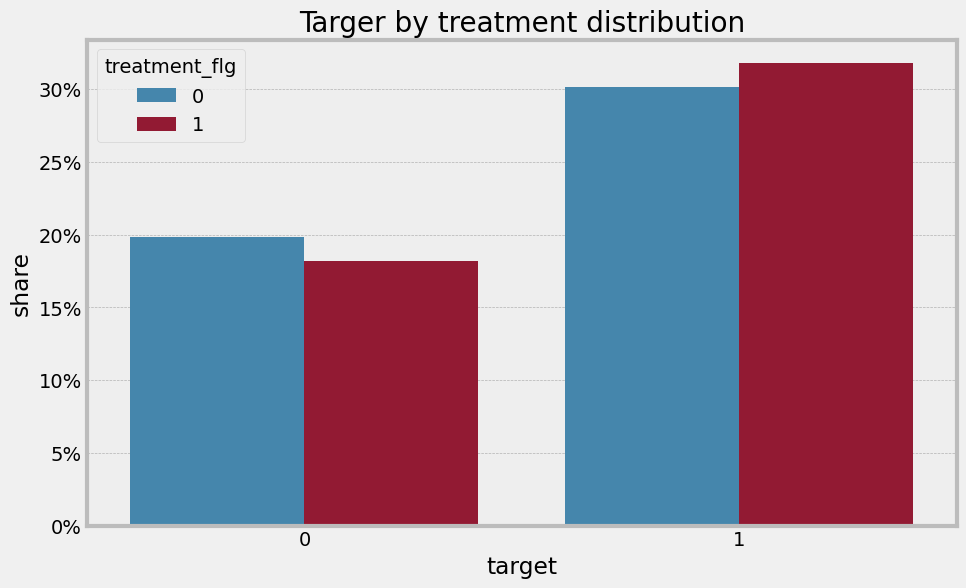

In [6]:
fig, ax = plt.subplots()

uplift_train_df \
    .groupby(["treatment_flg", "target"], as_index=False) \
    .size() \
    .assign(share = lambda x: x["size"] / x["size"].sum()) \
    .pipe((sns.barplot, "data"),
        x="target",
        y="share",
        hue="treatment_flg",
        ax=ax
    )
ax.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda y, _: f"{y :.0%}")
)
ax.set(title="Targer by treatment distribution");

We have approximately 50/50 split of the `treatment_flg` but the `target` is not balanced (approx. 40/60).

 Now we examine the clients data. First we count the unique number of `client_id`.

In [7]:
assert clients_df.shape[0] == clients_df["client_id"].nunique()
assert uplift_train_df.shape[0] == uplift_train_df["client_id"].nunique()

print(f"""
clients_id
----------
clients_df: {clients_df["client_id"].nunique()}
uplift_train_df: {uplift_train_df["client_id"].nunique()}
""")


clients_id
----------
clients_df: 400162
uplift_train_df: 200039



We have more `client_id` in the `clients_df`. Next we merge the data by `client_id`.

In [8]:
raw_data_df = pd.merge(
    left=clients_df,
    right=uplift_train_df,
    on="client_id",
    how="outer"
)

assert raw_data_df.shape[0] == clients_df.shape[0]
assert raw_data_df.shape[0] == raw_data_df["client_id"].nunique()

We continue by taking a look into the `gender` feature.

**Warning:** Including `gender`-like variables in ML models can induce undesirable biases. We do keep this feature just because we want to compare the techniques with the original example. 

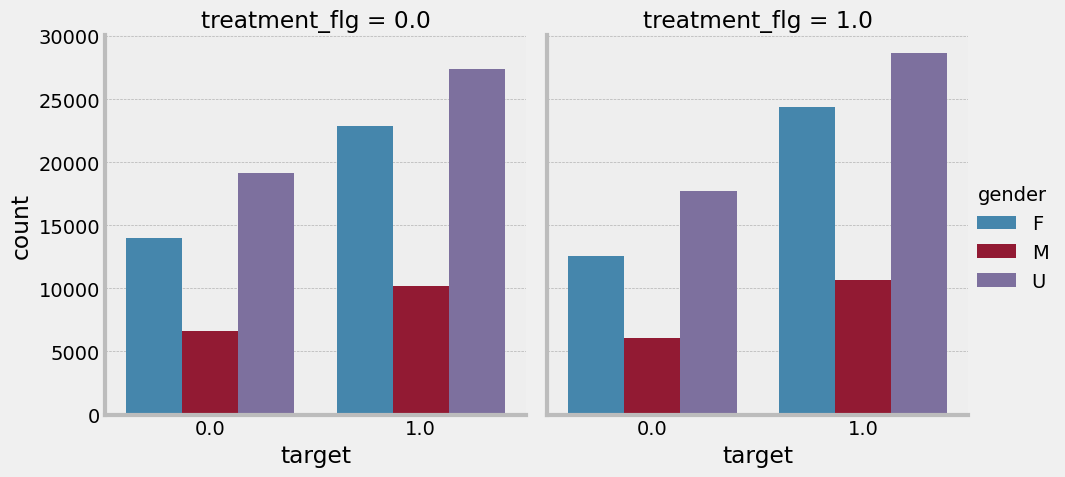

In [9]:
g = raw_data_df \
    .query("target.notnull()") \
    .groupby(["treatment_flg", "target", "gender"], as_index=False) \
    .agg(count=("client_id", "count")) \
    .pipe((sns.catplot, "data"),
        x="target",
        y="count",
        hue="gender",
        col="treatment_flg",
        kind="bar"
    );

Now we plot the `age distribution`. Note however, we need to remove some outliers:

In [10]:
# reasonable age range
good_age_mask = "10 < age < 100"

print(f"""
Rows with age outliers: 
{1 - clients_df.query(good_age_mask).shape[0] / clients_df.shape[0]: 0.2%}
""")


Rows with age outliers: 
 0.37%



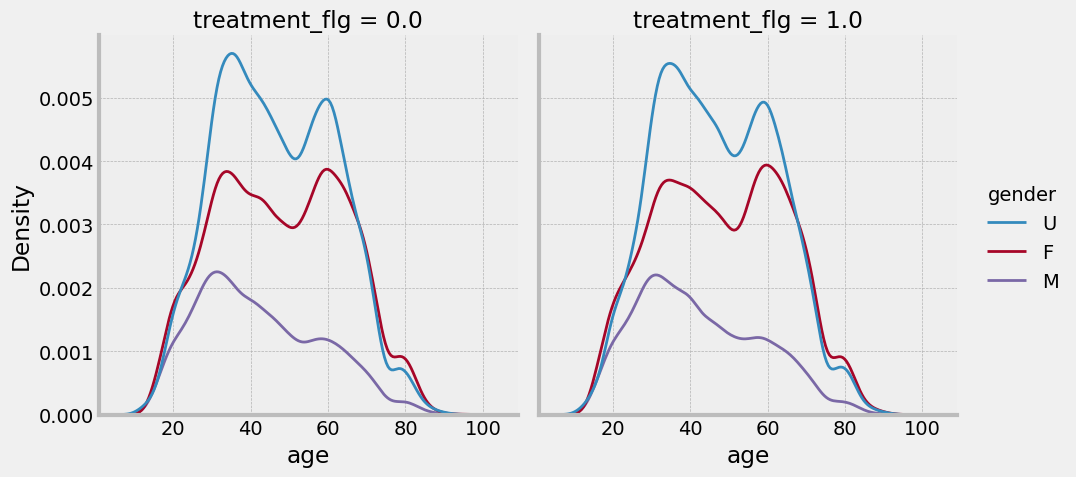

In [11]:
raw_data_df \
    .query("(target.notnull()) and (10 < age < 100)") \
    .pipe((sns.displot, "data"),
        x="age",
        hue="gender",
        col="treatment_flg",
        kind="kde"
    )

We continue by studying the time variables. Note that the variable `first_redeem_date` has missing values. Let us see target and treatment distribution over these missing values.

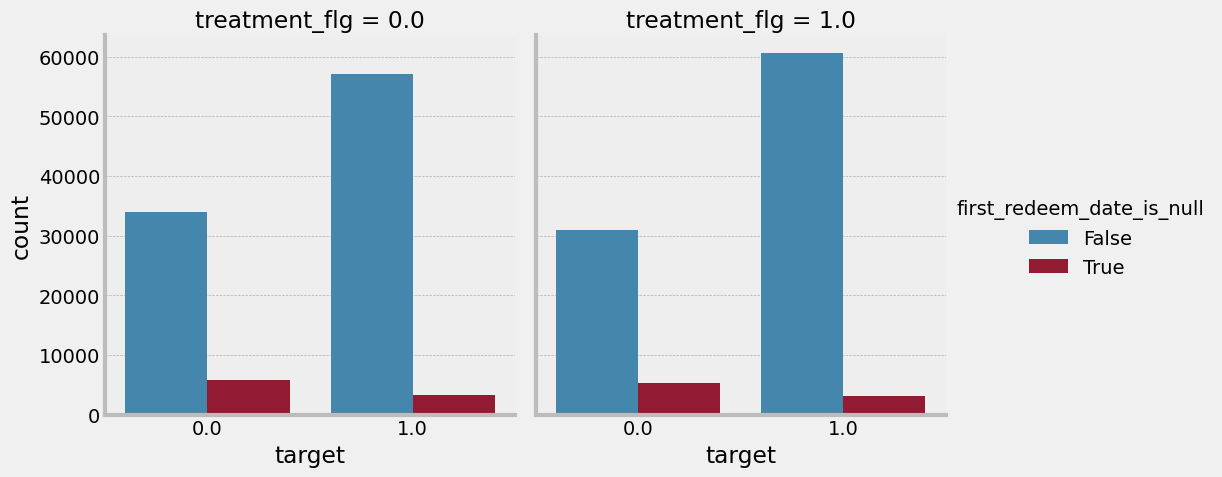

In [12]:
g = raw_data_df \
    .assign(first_redeem_date_is_null = lambda x: x["first_redeem_date"].isna()) \
    .groupby(["treatment_flg", "target", "first_redeem_date_is_null"], as_index=False) \
    .agg(count=("client_id", "count")) \
    .pipe((sns.catplot, "data"),
        x="target",
        y="count",
        hue="first_redeem_date_is_null",
        col="treatment_flg",
        kind="bar"
    );

We do not see any pattern at first glance. Let us see the development the client counts over `first_issue_date`.

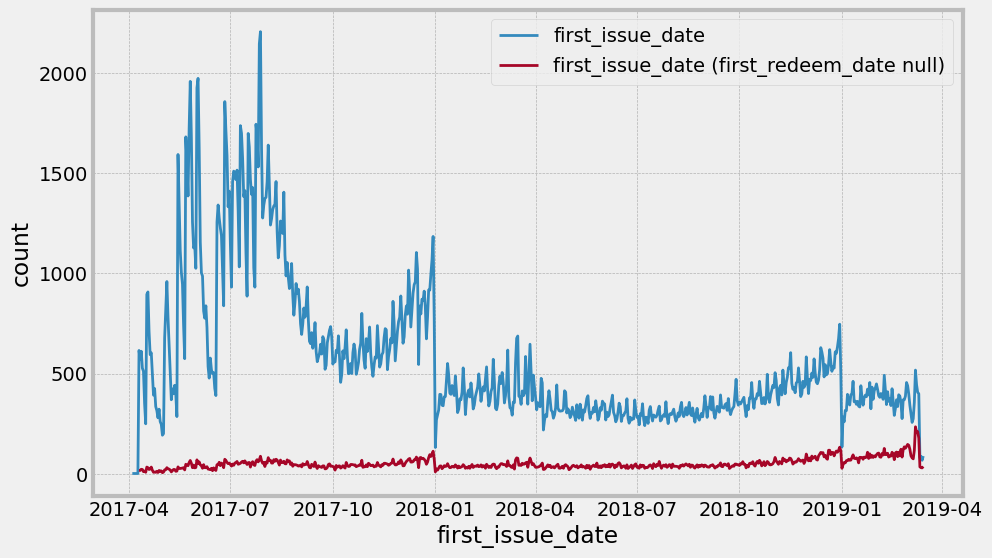

In [13]:
fig, ax = plt.subplots()

raw_data_df \
    .assign(first_issue_date =  lambda x: x["first_issue_date"].dt.date) \
    .groupby(["first_issue_date"], as_index=False) \
    .agg(count=("client_id", "count")) \
    .pipe((sns.lineplot, "data"),
        x="first_issue_date",
        y="count",
        label="first_issue_date",
        ax=ax
    )

raw_data_df \
    .query("first_redeem_date.isnull()") \
    .assign(first_issue_date =  lambda x: x["first_issue_date"].dt.date) \
    .groupby(["first_issue_date"], as_index=False) \
    .agg(count=("client_id", "count")) \
    .pipe((sns.lineplot, "data"),
        x="first_issue_date",
        y="count",
        label="first_issue_date (first_redeem_date null)",
        ax=ax
    );

There seems to be missing values along the whole time period.

In [14]:
print(f"""
rows share with missing values:
{raw_data_df.query("first_redeem_date.isnull()").shape[0] / raw_data_df.shape[0]: 0.2%}
""")


rows share with missing values:
 8.86%



From this initial EDA there is no hint of the source of these missing values, i.e. they are at random (or maybe we are missing some information or context of the data?).

We now plot the client counts over `first_issue_date` and `first_redeem_date`:

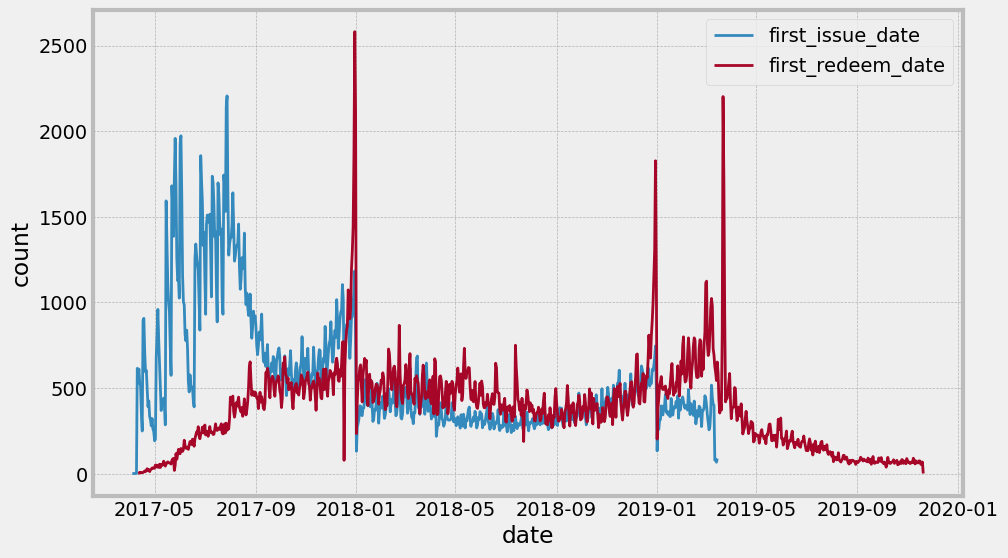

In [15]:
fig, ax = plt.subplots()

raw_data_df \
    .assign(first_issue_date =  lambda x: x["first_issue_date"].dt.date) \
    .groupby(["first_issue_date"], as_index=False) \
    .agg(count=("client_id", "count")) \
    .pipe((sns.lineplot, "data"),
        x="first_issue_date",
        y="count",
        label="first_issue_date",
        ax=ax,
    )

raw_data_df\
    .assign(first_redeem_date =  lambda x: x["first_redeem_date"].dt.date) \
    .groupby(["first_redeem_date"], as_index=False) \
    .agg(count=("client_id", "count")) \
    .pipe((sns.lineplot, "data"),
        x="first_redeem_date",
        y="count",
        label="first_redeem_date",
        ax=ax,
    )
ax.set(xlabel="date", ylabel="count");

Finally, in order to enrich our models, we calculate some simple summary metrics from the purchase data:

In [16]:
client_purchases_summary_df = purchases_df \
    .groupby(["client_id"], as_index=False) \
    .agg(
        n_transactions=("transaction_id", "count"),
        n_products=("product_id", "nunique"),
        n_stores=("store_id", "nunique"),
        last_transaction_date = ("transaction_datetime", "max"),
        express_points_received = ("express_points_received", np.sum),
        express_points_spent = ("express_points_spent", np.sum),
        regular_points_spent = ("regular_points_spent", np.sum),
        mean_product_quantity = ("product_quantity", np.mean),
    ) \
    .assign(
        last_transaction_date = lambda x: pd.to_datetime(x["last_transaction_date"])
    )

**Warning:** We are using time-dependent features like ` last_transaction_date = ("transaction_datetime", "max")`, which have to be treated carefully when doing out-of-sample validation. Below we will do a train-test split by randomly selecting a fraction of the data bases on the `client_id`. Nevertheless, to have a faithful out-of-sample evaluation metrics we might want to compute these features on each split otherwise we would be leaking information. For the sake of this toy-example we will not do this.

## Prepare Data

In this section we prepare the data for uplift modeling. We will use the features from the original example (with minor modifications) plus some purchase features.

In [17]:
# add purchase features
raw_data_ext_df = raw_data_df \
    .copy() \
    .merge(
        right=client_purchases_summary_df,
        on="client_id",
        how="left"
    )

In [18]:
transformation_map = {
    "first_issue_time": 
        lambda x: (x["first_issue_date"] - pd.Timestamp("2017-01-01")).dt.days,
    "first_issue_time_weekday":
        lambda x: x["first_issue_date"].dt.weekday,
    "first_issue_time_month":
        lambda x: x["first_issue_date"].dt.month,
    "first_redeem_time" : 
        lambda x: (x["first_redeem_date"] - pd.Timestamp("2017-01-01")).dt.days,
    "issue_redeem_delay":
        lambda x: (x["first_redeem_time"] - x["first_issue_time"]) ,
    "last_transaction_time":
        lambda x: (x["last_transaction_date"] - pd.Timestamp("2017-01-01")).dt.days,
}

data_df = raw_data_ext_df \
    .copy() \
    .query("target.notnull()") \
    .query(good_age_mask) \
    .set_index("client_id") \
    .assign(**transformation_map) \
    .sort_values("first_issue_time") \
    .drop(columns=[
            "first_issue_date",
            "first_redeem_date",
            "last_transaction_date",
        ]
    )

data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199305 entries, b5e94fd9dd to 903a531bb7
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   age                       199305 non-null  int64  
 1   gender                    199305 non-null  object 
 2   treatment_flg             199305 non-null  float64
 3   target                    199305 non-null  float64
 4   n_transactions            199305 non-null  int64  
 5   n_products                199305 non-null  int64  
 6   n_stores                  199305 non-null  int64  
 7   express_points_received   199305 non-null  float64
 8   express_points_spent      199305 non-null  float64
 9   regular_points_spent      199305 non-null  float64
 10  mean_product_quantity     199305 non-null  float64
 11  first_issue_time          199305 non-null  int64  
 12  first_issue_time_weekday  199305 non-null  int64  
 13  first_issue_time_month    199305 non

We can now show a pair-plot of the main features of the original example:

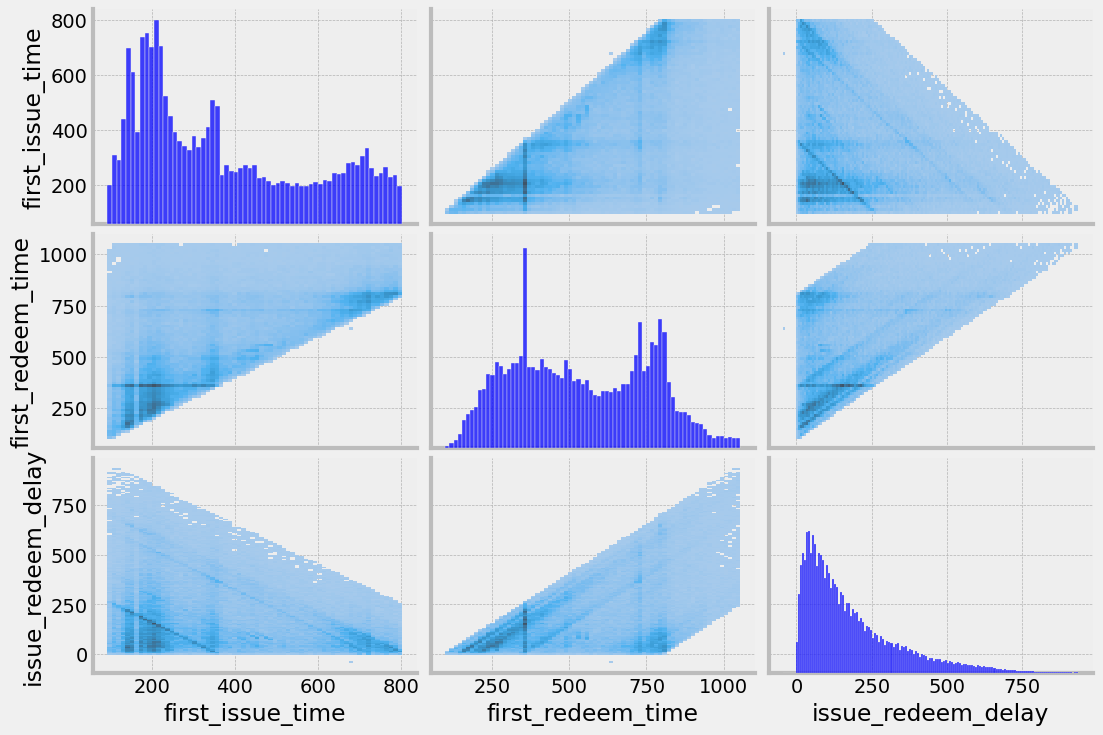

In [19]:
sns.pairplot(
    data=data_df[[
        "first_issue_time",
        "first_redeem_time",
        "issue_redeem_delay",
    ]],
    kind="hist",
    height=2.5,
    aspect=1.5
);

Now we do a simple train-validation split of the data.

In [20]:
target_col = "target"
treatment_col = "treatment_flg"

y = data_df[target_col]
w = data_df[treatment_col]
x = data_df.drop(columns=[treatment_col, target_col])

idx_train, idx_val = train_test_split(
    data_df.index,
    test_size=0.3,
    random_state=42,
    stratify=(y.astype(str) + "_" + w.astype(str))
)

x_train = x.loc[idx_train]
x_val = x.loc[idx_val]

w_train = w.loc[idx_train]
w_val = w.loc[idx_val]

y_train = y.loc[idx_train]
y_val = y.loc[idx_val]

Let us encode the `gender` as an ordinal categorical variable.

In [21]:
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(x_train[["gender"]])

x_train_transformed = x_train.assign(
    gender = lambda x: ordinal_encoder.transform(x[["gender"]])
)

x_val_transformed = x_val.assign(
    gender = lambda x: ordinal_encoder.transform(x[["gender"]])
)

## Propensity Score Model

The propensity score are defined as $p(X_{i}) = P(W_{i}=1 | X_{i})$, that is, the probability of having a treatment given the covariates. If the treatment assignment is at random these scores should be concentrated around 0.5. For a nice introduction to the subject you can see ["Propensity Score Matching: A Non-experimental Approach to Causal Inference" by Michael Johns, PyData New York 2019](https://www.youtube.com/watch?v=gaUgW7NWai8). We ser `scikit-learn`'s [`HistGradientBoostingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html). For this model we need to explicitly indicate the categorical variables:

In [22]:
categorical_features = ["gender"]

hgc_params = {
    "categorical_features": 
    np.argwhere(
        [
            col in categorical_features
            for col in x_train_transformed.columns
        ]
    ).flatten()
}

We now fit the model:

In [23]:
propensity_model = HistGradientBoostingClassifier(**hgc_params)

propensity_model.fit(X=x_train_transformed, y=w_train)
p_train = propensity_model.predict_proba(X=x_train_transformed)
p_val = propensity_model.predict_proba(X=x_val_transformed) 

p_train = pd.Series(p_train[:, 0], index=idx_train)
p_val = pd.Series(p_val[:, 0], index=idx_val)

Lets see the results:

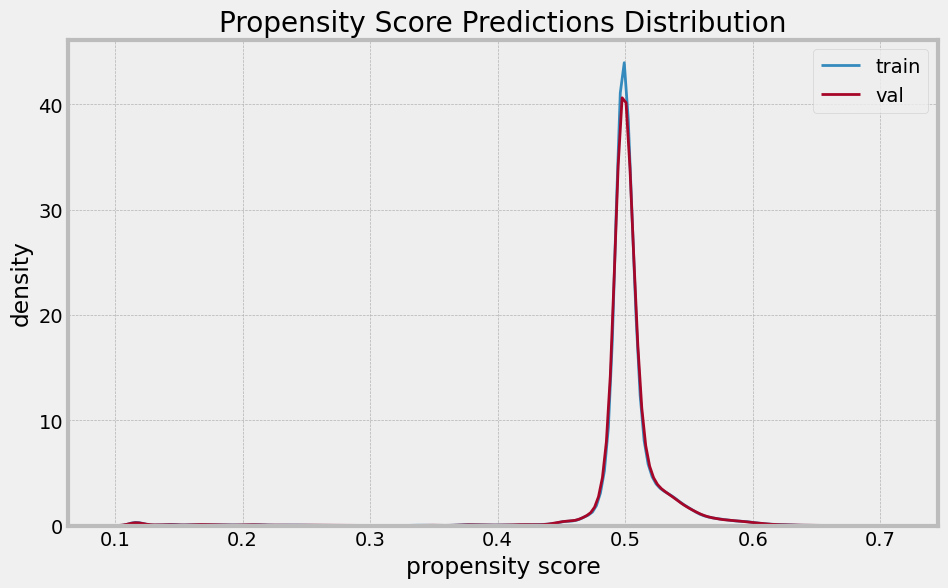

In [24]:
fig, ax = plt.subplots()
sns.kdeplot(x=p_train, label="train", ax=ax)
sns.kdeplot(x=p_val, label="val", ax=ax)
ax.legend()
ax.set(
    title="Propensity Score Predictions Distribution",
    xlabel="propensity score",
    ylabel="density"
);

In [25]:
print(f"""
Share of predictions with |p - 0.5| > 0.2 (train) {p_train[abs(p_train - 0.5) > 0.2].size / p_train.size : 0.2%}
Share of predictions with |p - 0.5| > 0.2 (val) {p_val[abs(p_val - 0.5) > 0.2].size / p_val.size : 0.2%}
""")


Share of predictions with |p - 0.5| > 0.2 (train)  1.25%
Share of predictions with |p - 0.5| > 0.2 (val)  1.26%



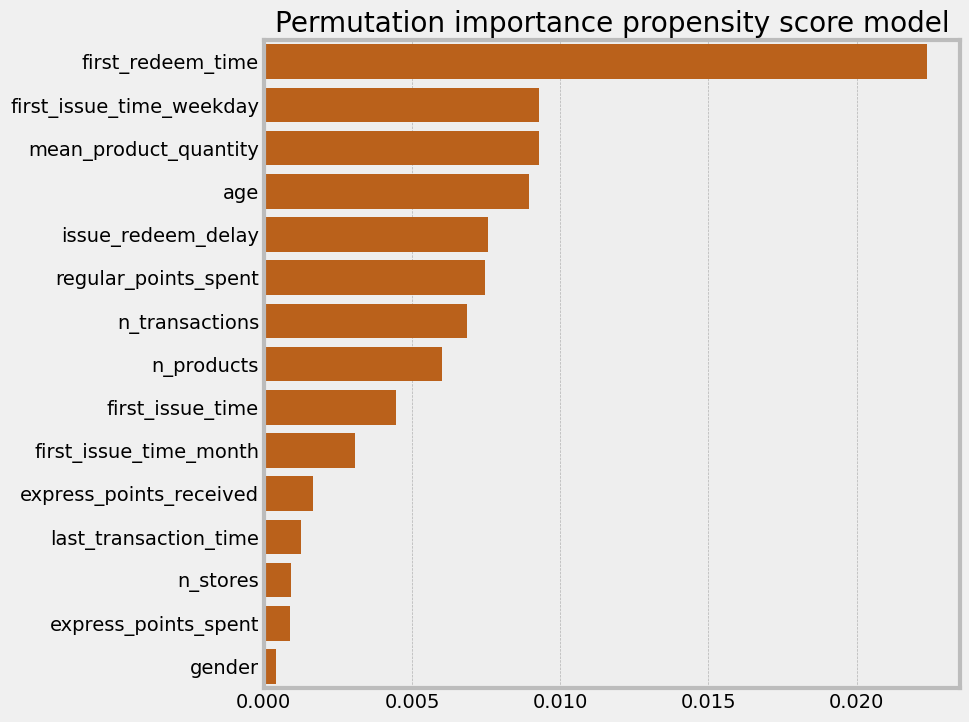

In [26]:
from sklearn.inspection import permutation_importance

pi = permutation_importance(
    estimator=propensity_model,
    X=x_train_transformed,
    y=w_train
)

fig, ax = plt.subplots(figsize=(8, 8))

idx = pi["importances_mean"].argsort()[::-1]

sns.barplot(
    x=pi["importances_mean"][idx],
    y=x_train_transformed.columns[idx],
    color="C4",
    ax=ax
)
ax.set(title="Permutation importance propensity score model");

## Data Container

We now define a convenient data structure for the uplift  models input data.

In [27]:
from dataclasses import dataclass

@dataclass
class DataIn:
    x: pd.DataFrame
    x_transformed: np.array
    y: pd.Series
    treatment: pd.Series
    p: pd.Series

data_train = DataIn(
    x=x_train,
    x_transformed=x_train_transformed,
    y=y_train,
    treatment=w_train,
    p=p_train
)

data_val = DataIn(
    x=x_val,
    x_transformed=x_val_transformed,
    y=y_val,
    treatment=w_val,
    p=p_val
)

---

## Models

Now that we have a better understanding of the data we can start modeling. We use some of the *meta-learners* from [`causalml`](https://github.com/uber/causalml). For more details please see the [`causalml` documentation](https://causalml.readthedocs.io/en/latest/methodology.html#meta-learner-algorithms).

### S-Learner

In this meta-model we simply train an ML model to predict the `target` variable using the covariates $X$ plus the `target` as regressors.

-  **Step 1: Training**

$$
\underbrace{
\left(
\begin{array}{cccc}
x_{11} & \cdots & x_{1k} & w_{1} \\
\vdots & \ddots & \vdots & \vdots \\
x_{11} & \cdots & x_{nk} & w_{n} \\
\end{array}
\right)}_{X\bigoplus W}
\xrightarrow{\mu}
\left(
\begin{array}{c}
y_{1} \\
\vdots \\
y_{n}
\end{array}
\right)
$$

- **Step 2: Uplift Prediction**

$$
\widehat{\text{\bf{uplift}}} = 
\hat{\mu}\left(
\begin{array}{cccc}
x_{11} & \cdots & x_{1k} & 1 \\
\vdots & \ddots & \vdots & \vdots \\
x_{11} & \cdots & x_{mk} & 1 \\
\end{array}
\right)
-
\hat{\mu}
\left(
\begin{array}{cccc}
x_{11} & \cdots & x_{1k} & 0 \\
\vdots & \ddots & \vdots & \vdots \\
x_{11} & \cdots & x_{mk} & 0 \\
\end{array}
\right)
$$

In [28]:
s_learner = BaseSClassifier(
    learner=HistGradientBoostingClassifier(**hgc_params)
)

s_ate = s_learner.estimate_ate(
    X=data_train.x_transformed,
    treatment=data_train.treatment,
    y=data_train.y
)

One can access the trained model as:

In [29]:
s_learner.models[1]

HistGradientBoostingClassifier(categorical_features=array([1]))

### T-Learner

For this one we train two ML models instead: one for each treatment assignment.

- **Step 1: Training**

$$
\underbrace{
\left(
\begin{array}{ccc}
x_{11} & \cdots & x_{1k} \\
\vdots & \ddots & \vdots \\
x_{11} & \cdots & x_{n_{C}k} \\
\end{array}
\right)}_{X|_{\text{control}}}
\xrightarrow{\mu_{C}}
\left(
\begin{array}{c}
y_{1} \\
\vdots \\
y_{n_{C}}
\end{array}
\right)
$$

$$
\underbrace{
\left(
\begin{array}{ccc}
x_{11} & \cdots & x_{1k}  \\
\vdots & \ddots & \vdots \\
x_{11} & \cdots & x_{n_{T}k} \\
\end{array}
\right)}_{X |_{\text{treatment}}}
\xrightarrow{\mu_{T}}
\left(
\begin{array}{c}
y_{1} \\
\vdots \\
y_{n_{T}}
\end{array}
\right) 
$$

- **Step 2: Uplift Prediction**

$$
\widehat{\text{\bf{uplift}}} = 
\hat{\mu}_{T}\left(
\begin{array}{cccc}
x_{11} & \cdots & x_{1k} \\
\vdots & \ddots & \vdots \\
x_{11} & \cdots & x_{mk} \\
\end{array}
\right)
-
\hat{\mu}_{C}
\left(
\begin{array}{cccc}
x_{11} & \cdots & x_{1k} \\
\vdots & \ddots & \vdots \\
x_{11} & \cdots & x_{mk} \\
\end{array}
\right)
$$

In [30]:
t_learner = BaseTClassifier(
    learner=HistGradientBoostingClassifier(**hgc_params)
)

t_ate_lwr, t_ate, t_ate_upr = t_learner.estimate_ate(
    X=data_train.x_transformed,
    treatment=data_train.treatment,
    y=data_train.y)

One can access the trained models as:

In [31]:
t_learner.models_c[1] # control group
t_learner.models_t[1] # treatment group

HistGradientBoostingClassifier(categorical_features=array([1]))

### X-Learner

The X-Learner is similar to the T-Learner but it adds and additional step where we transfer information from one model to the other, see [Sören, R, et.al. (2019) *"Meta-learners for Estimating Heterogeneous Treatment Effects using Machine Learning"*](https://arxiv.org/abs/1706.03461) for details on the motivation.

- **Step 1: Training**

$$
\underbrace{
\left(
\begin{array}{ccc}
x_{11} & \cdots & x_{1k} \\
\vdots & \ddots & \vdots \\
x_{11} & \cdots & x_{n_{C}k} \\
\end{array}
\right)}_{X|_{\text{control}}}
\xrightarrow{\mu_{C}}
\left(
\begin{array}{c}
y_{1} \\
\vdots \\
y_{n_{C}}
\end{array}
\right)
$$

$$
\underbrace{
\left(
\begin{array}{ccc}
x_{11} & \cdots & x_{1k}  \\
\vdots & \ddots & \vdots \\
x_{11} & \cdots & x_{n_{T}k} \\
\end{array}
\right)}_{X |_{\text{treatment}}}
\xrightarrow{\mu_{T}}
\left(
\begin{array}{c}
y_{1} \\
\vdots \\
y_{n_{T}}
\end{array}
\right) 
$$

- **Step 2: Compute imputed treatment effects**

$$
\tilde{D}^{T} \coloneqq
\left(
\begin{array}{c}
y_{1} \\
\vdots \\
y_{n_{T}}
\end{array}
\right)
- 
\hat{\mu}_{C}
\left(
\begin{array}{cccc}
x_{11} & \cdots & x_{1k} \\
\vdots & \ddots & \vdots \\
x_{11} & \cdots & x_{n_{T}k} \\
\end{array}
\right)
$$

$$
\tilde{D}^{C} \coloneqq
\hat{\mu}_{T}
\left(
\begin{array}{cccc}
x_{11} & \cdots & x_{1k} \\
\vdots & \ddots & \vdots \\
x_{11} & \cdots & x_{n_{C}k} \\
\end{array}
\right)
-
\left(
\begin{array}{c}
y_{1} \\
\vdots \\
y_{n_{C}}
\end{array}
\right)
$$

- **Step 3: Uplift train with different targets**

$$
\underbrace{
\left(
\begin{array}{ccc}
x_{11} & \cdots & x_{1k} \\
\vdots & \ddots & \vdots \\
x_{11} & \cdots & x_{n_{C}k} \\
\end{array}
\right)}_{X|_{\text{control}}}
\xrightarrow{\tau_{C}}
\left(
\begin{array}{c}
\tilde{D}^{C}_{1} \\
\vdots \\
\tilde{D}^{C}_{n_{T}}
\end{array}
\right)
$$

$$
\underbrace{
\left(
\begin{array}{ccc}
x_{11} & \cdots & x_{1k} \\
\vdots & \ddots & \vdots \\
x_{11} & \cdots & x_{n_{C}k} \\
\end{array}
\right)}_{X|_{\text{treatment}}}
\xrightarrow{\tau_{T}}
\left(
\begin{array}{c}
\tilde{D}^{T}_{1} \\
\vdots \\
\tilde{D}^{T}_{n_{T}}
\end{array}
\right)
$$

- **Step 4: Uplift Prediction**

$$
\widehat{\text{\bf{uplift}}} = g(x)\hat{\tau}_{C}(x) + (1 - g(x))\hat{\tau}_{T}(x)
$$

where $g(x) \in [0, 1]$ is a weight function.

**Remark:** From [Sören, R, et.al. (2019) *"Meta-learners for Estimating Heterogeneous Treatment Effects using Machine Learning"*](https://arxiv.org/abs/1706.03461):
> *$\hat{\tau}_{C}$ and $\hat{\tau}_{T}$ are both estimators for $\tau$ (the uplift) while $g$ is chosen to combine these estimators to one improved estimator $\hat{\tau}$. Based on our experience, we observe that it is good to use an estimate of the propensity score for $g$, but it also makes sense to choose $g = 1$ or $0$, if the number of treated units is very large or small compared to the number of control units.*

In [32]:
x_learner = BaseXClassifier(
    outcome_learner=HistGradientBoostingClassifier(**hgc_params),
    effect_learner=HistGradientBoostingRegressor(**hgc_params),
)

x_ate_lwr, x_ate, x_ate_upr = x_learner.estimate_ate(
    X=data_train.x_transformed,
    treatment=data_train.treatment,
    y=data_train.y,
    p=data_train.p
)

One can access the trained models as:

In [33]:
# step 1
x_learner.models_mu_c[1] # control group
x_learner.models_mu_t[1] # treatment group
# step 3
x_learner.models_tau_c[1] # control group
x_learner.models_tau_t[1] # treatment group

HistGradientBoostingRegressor(categorical_features=array([1]))

---

## Predictions & Diagnostics

Next, now that we have fitted meta-learner models, we generate predictions in the training and validations sets.

In [34]:
@dataclass
class DataOut:
    meta_learner_name: str
    meta_learner: BaseLearner
    y_pred: np.array

# in-sample predictions
data_out_train_s = DataOut(
    meta_learner_name="S-Learner",
    meta_learner=s_learner,
    y_pred=s_learner.predict(
        X=data_train.x_transformed, treatment=data_train.treatment
    )
)
data_out_train_t = DataOut(
    meta_learner_name="T-Learner",
    meta_learner=t_learner,
    y_pred=t_learner.predict(
        X=data_train.x_transformed, treatment=data_train.treatment
    )
)
data_out_train_x = DataOut(
    meta_learner_name="X-Learner",
    meta_learner=x_learner,
    y_pred=x_learner.predict(
        X=data_train.x_transformed, treatment=data_train.treatment, p=data_train.p
    )
)
# out-of-sample predictions
data_out_val_s = DataOut(
    meta_learner_name="S-Learner",
    meta_learner=s_learner,
    y_pred=s_learner.predict(
        X=data_val.x_transformed, treatment=data_val.treatment
    )
)
data_out_val_t = DataOut(
    meta_learner_name="T-Learner",
    meta_learner=t_learner,
    y_pred=t_learner.predict(
        X=data_val.x_transformed, treatment=data_val.treatment
    )
)
data_out_val_x = DataOut(
    meta_learner_name="X-Learner",
    meta_learner=x_learner,
    y_pred=x_learner.predict(
        X=data_val.x_transformed, treatment=data_val.treatment, p=data_val.p
    )
)

X has feature names, but HistGradientBoostingClassifier was fitted without feature names
X has feature names, but HistGradientBoostingClassifier was fitted without feature names
X has feature names, but HistGradientBoostingClassifier was fitted without feature names
X has feature names, but HistGradientBoostingClassifier was fitted without feature names


A natural question is: how well do we predict the uplift? Note that ([Gutierrez, P., & Gérardy, J. Y. (2017). *"Causal Inference and Uplift Modelling: A Review of the Literature"*](https://proceedings.mlr.press/v67/gutierrez17a/gutierrez17a.pdf)):

> *In machine learning, the standard is to use cross-validation: separate the data into a training and a testing datasets; learn on the training data, predict the target on the test data and compare to the ground truth. In uplift modeling, cross validation is still a valid idea but there is no more ground truth because we can never observe the e↵ect of being treated and not treated on a person at the same time.*

To answer it we deep dive into some common model diagnostic tools.

### Perfect uplift prediction

How would a perfect uplift model predict? Following [Diemert, Eustache, et.al. (2020) "A Large Scale Benchmark for Uplift Modeling"](http://ama.imag.fr/~amini/Publis/large-scale-benchmark.pdf),
> A perfect model assigns higher scores to all treated individuals with positive outcomes than any individuals with negative outcomes.

In [35]:
def perfect_uplift_model(data: DataIn):
    # control Responders
    cr_num = np.sum((data.y == 1) & (data.treatment == 0))
    # treated Non-Responders
    tn_num = np.sum((data.y == 0) & (data.treatment == 1))

    # compute perfect uplift curve
    summand = data.y if cr_num > tn_num else data.treatment
    return 2 * (data.y == data.treatment) + summand

perfect_uplift_train = perfect_uplift_model(data=data_train)
perfect_uplift_val = perfect_uplift_model(data=data_val)

We can compare the sorted predictions of the models against the perfect one.

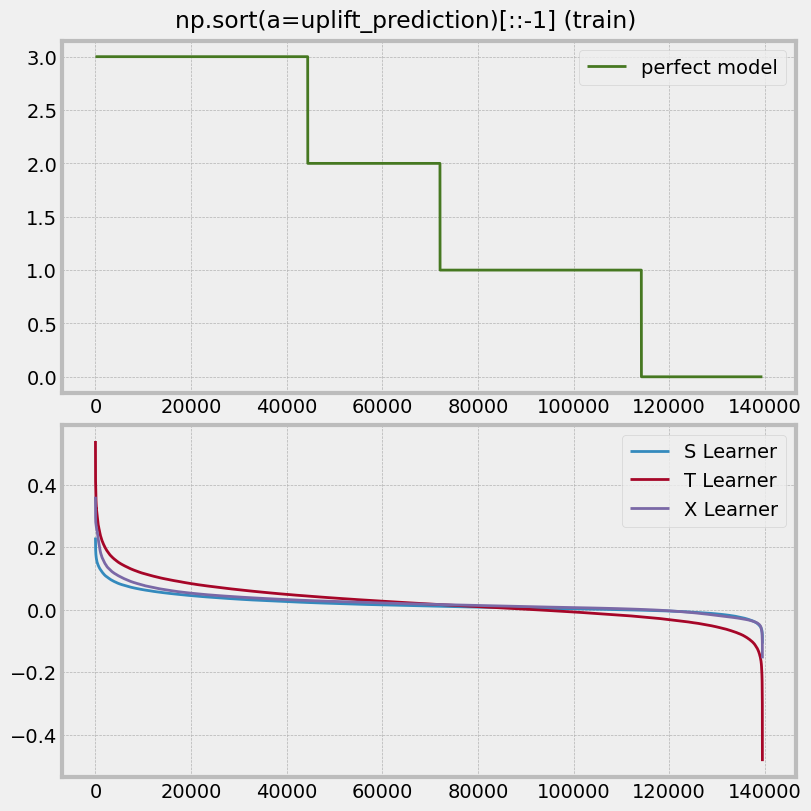

In [36]:
fig, ax =  plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(8, 8),
    layout="constrained"
)
sns.lineplot(
    x=range(data_train.y.size),
    y=np.sort(a=perfect_uplift_train)[::-1],
    color="C3",
    label="perfect model",
    ax=ax[0]
)
sns.lineplot(
    x=range(data_train.y.size),
    y=np.sort(a=data_out_train_s.y_pred.flatten())[::-1],
    color="C0",
    label="S Learner",
    ax=ax[1]
)
sns.lineplot(
    x=range(data_train.y.size),
    y=np.sort(a=data_out_train_t.y_pred.flatten())[::-1],
    color="C1",
    label="T Learner",
    ax=ax[1]
)
sns.lineplot(
    x=range(data_train.y.size),
    y=np.sort(a=data_out_train_x.y_pred.flatten())[::-1],
    color="C2",
    label="X Learner",
    ax=ax[1]
)
fig.suptitle("np.sort(a=uplift_prediction)[::-1] (train)");

### Uplift by percentile

1. Predict uplift for both treated and control observations
2. Compute the average prediction per percentile in both groups.
3. The difference between those averages is taken for each percentile. 

This difference gives an idea of the uplift gain per percentile. One can compute this using the `uplift_by_percentile` function (from [`sklift.metrics`](https://github.com/maks-sh/scikit-uplift/blob/master/sklift/metrics/metrics.py)). Let us see how the data looks for the S learner.

In [37]:
uplift_by_percentile_df = uplift_by_percentile(
    y_true=data_train.y,
    uplift=data_out_train_s.y_pred.flatten(),
    treatment=data_train.treatment,
    strategy="overall",
    total=True
)

uplift_by_percentile_df

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift
percentile,,,,,
0-10,6870,7082,0.608297,0.427845,0.180452
10-20,6974,6978,0.577144,0.485096,0.092048
20-30,7082,6870,0.610421,0.535662,0.074758
30-40,7200,6751,0.645278,0.574137,0.071141
40-50,7086,6865,0.665538,0.639476,0.026062
50-60,6959,6992,0.719213,0.691362,0.027851
60-70,6955,6996,0.747088,0.738136,0.008952
70-80,7002,6949,0.730934,0.740538,-0.009604
80-90,6927,7024,0.624946,0.656179,-0.031233


A well performing model would have large values in the first percentiles and decreasing values for larger ones. Now we can generate the plots:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


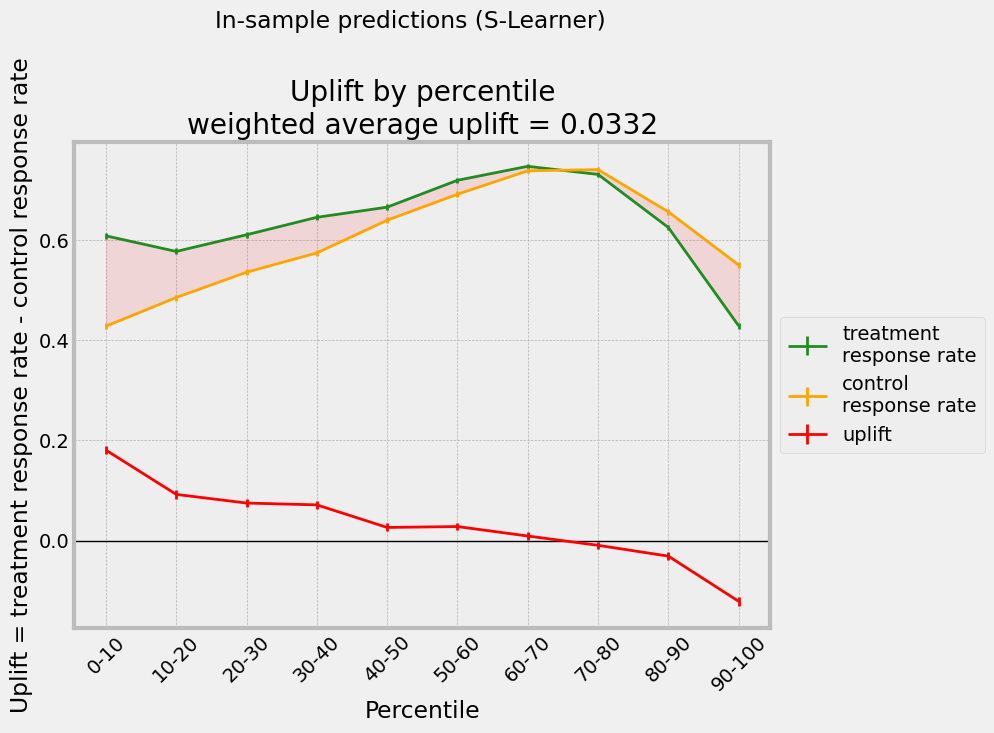

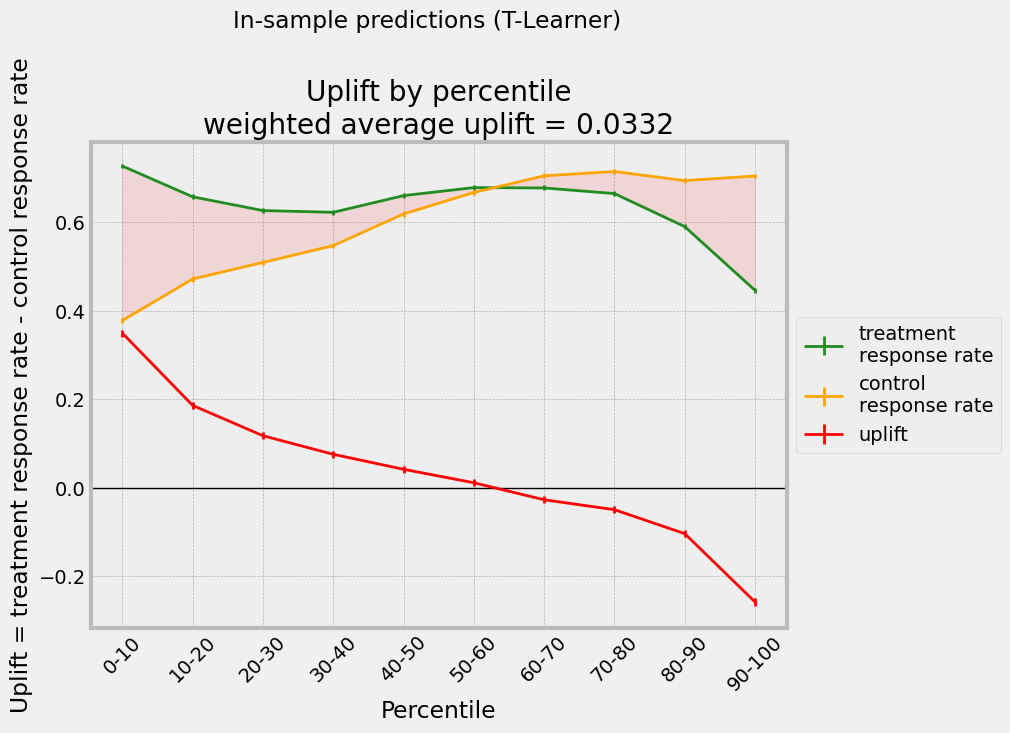

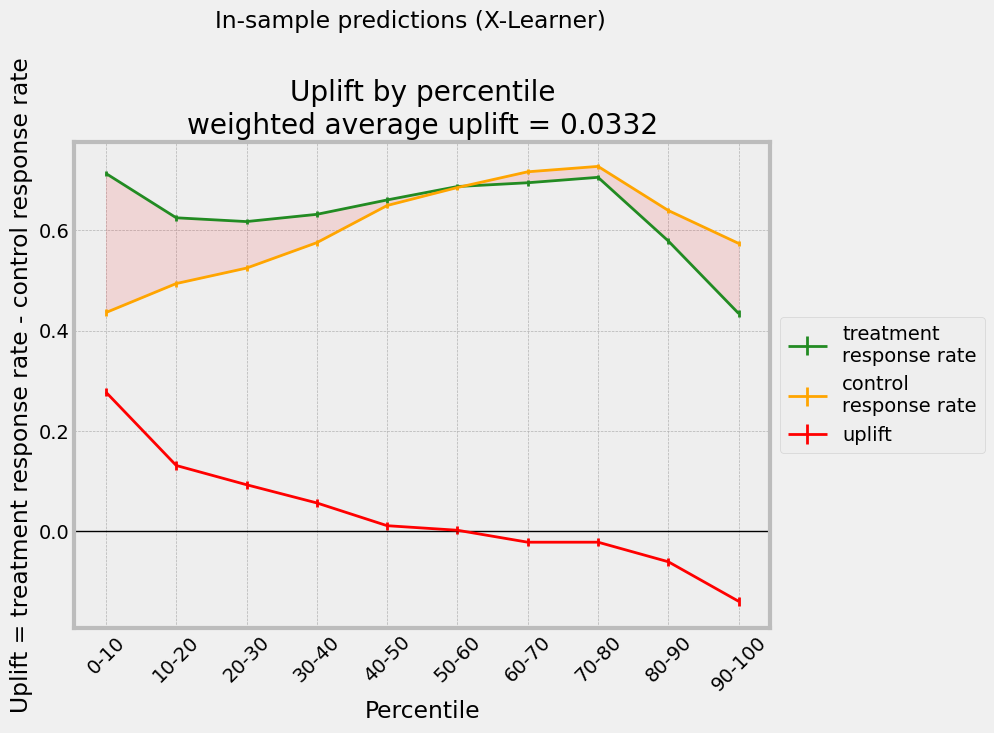

In [38]:
train_pred = [data_out_train_s, data_out_train_t, data_out_train_x]

for data_out_train in train_pred:
    ax = plot_uplift_by_percentile(
        y_true=data_train.y,
        uplift=data_out_train.y_pred.flatten(),
        treatment=data_train.treatment,
        strategy="overall",
        kind="line"
    )
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    fig = ax.get_figure()
    fig.suptitle(f"In-sample predictions ({data_out_train.meta_learner_name})", y=1.1)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


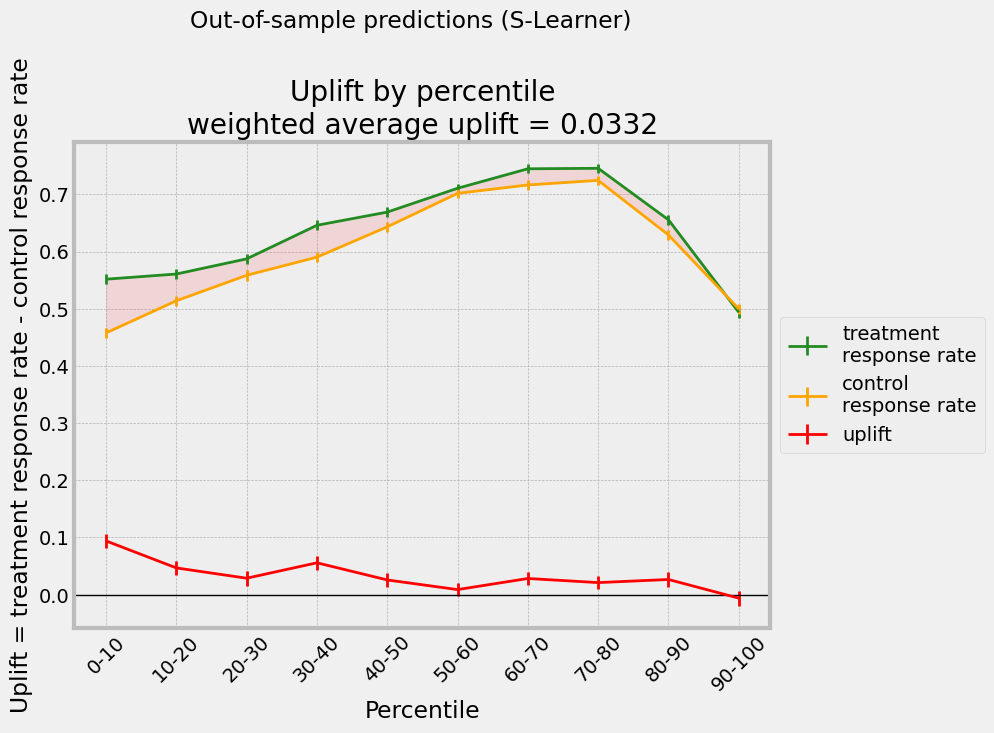

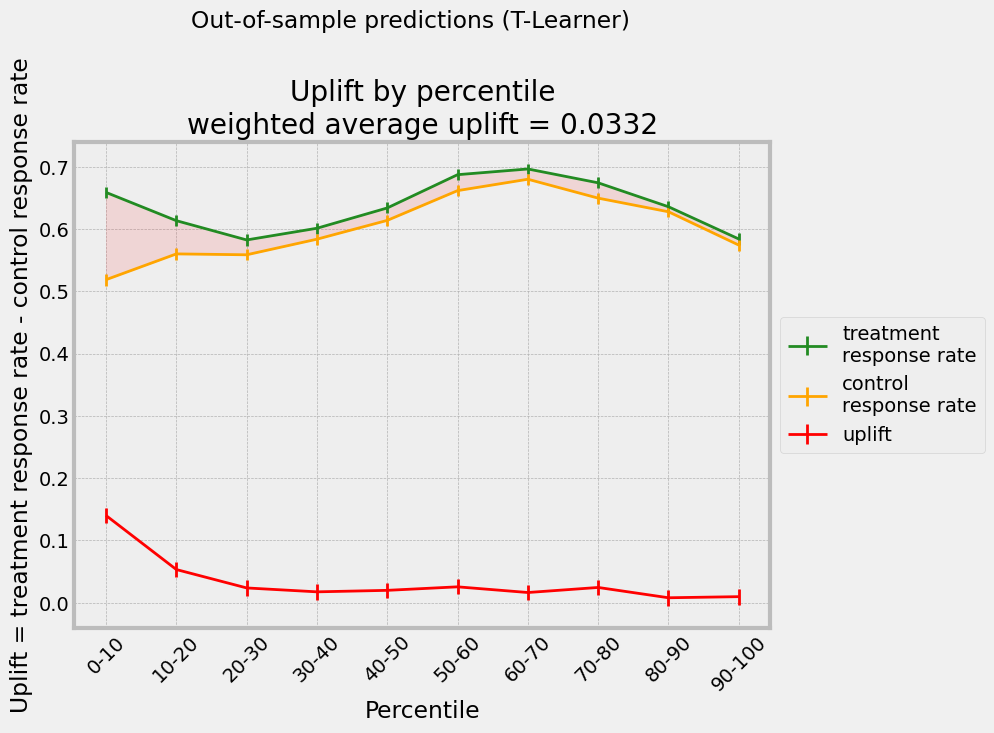

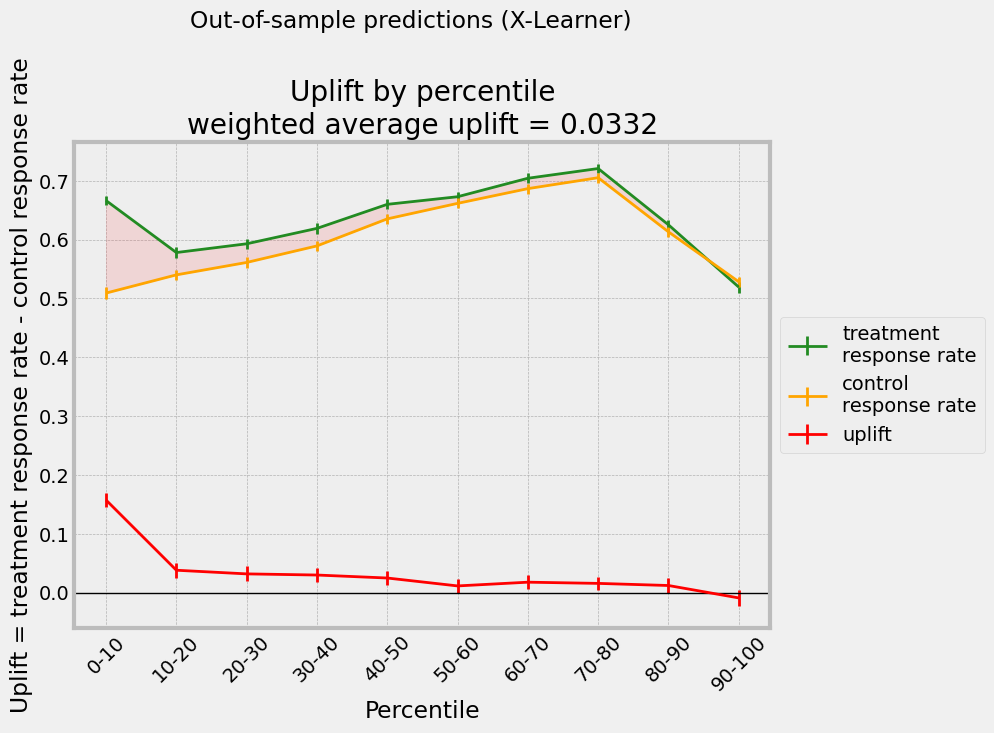

In [39]:
val_pred = [data_out_val_s, data_out_val_t, data_out_val_x]

for data_out_val in val_pred:
    ax = plot_uplift_by_percentile(
        y_true=data_val.y,
        uplift=data_out_val.y_pred.flatten(),
        treatment=data_val.treatment,
        strategy="overall",
        kind="line"
    )
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    fig = ax.get_figure()
    fig.suptitle(f"Out-of-sample predictions ({data_out_val.meta_learner_name})", y=1.1)

**Remark:** Here is the uplift by percentile table for the perfect model (train):

In [40]:
uplift_by_percentile_df = uplift_by_percentile(
    y_true=data_train.y,
    uplift=perfect_uplift_train,
    treatment=data_train.treatment,
    strategy="overall",
    total=False
)

uplift_by_percentile_df

Mean of empty slice.
invalid value encountered in double_scalars


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift
percentile,,,,,
0-10,13952,0,1.0,NaN,NaN
10-20,13952,0,1.0,NaN,NaN
20-30,13952,0,1.0,NaN,NaN
30-40,2539,11412,1.0,0.000000,1.0
40-50,0,13951,NaN,0.000000,NaN
50-60,0,13951,NaN,0.834636,NaN
60-70,0,13951,NaN,1.000000,NaN
70-80,0,13951,NaN,1.000000,NaN
80-90,11376,2575,0.0,1.000000,-1.0


### Cumulative gain chart

> *Predict uplift for both treated and control observations and compute the average prediction per decile (bins) in both groups. Then, the difference between those averages is taken for each decile.* ([Gutierrez, P., & Gérardy, J. Y. (2017). *"Causal Inference and Uplift Modelling: A Review of the Literature"*](https://proceedings.mlr.press/v67/gutierrez17a/gutierrez17a.pdf))

$$
\left(
\frac{Y^{T}}{N^{T}}
-
\frac{Y^{C}}{N^{C}}
\right)
(N^{T} + N^{C})
$$

> - $Y^{T} / Y^{C}$: sum of the treated / control individual outcomes  in the bin.
> - $N^{T} / N^{C}$: number of treated / control observations  in the bin.

We can compute this from the tables above. For example, for the S learner:

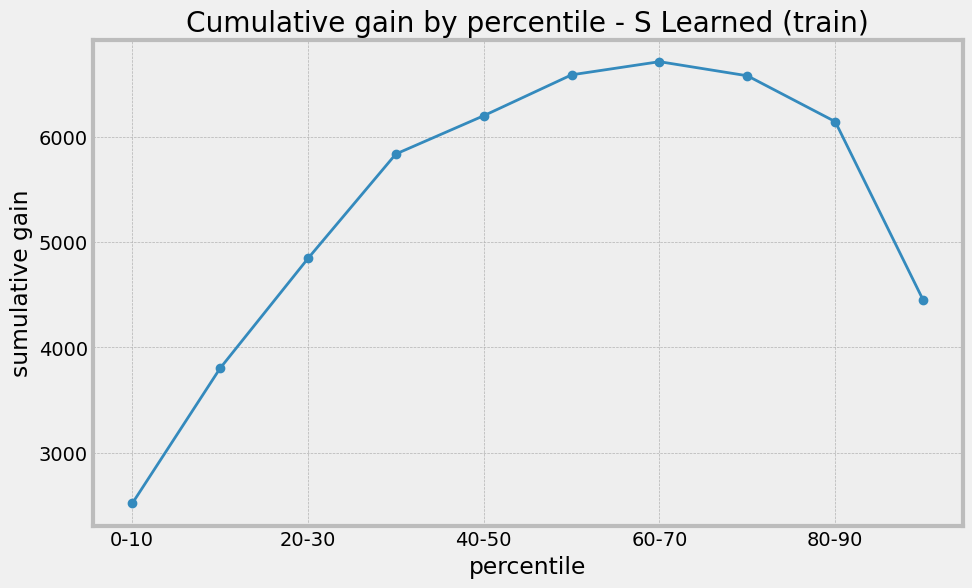

In [41]:
uplift_by_percentile_df = uplift_by_percentile(
    y_true=data_train.y,
    uplift=data_out_train_s.y_pred.flatten(),
    treatment=data_train.treatment,
    strategy="overall",
    total=False
)

fig, ax = plt.subplots()

uplift_by_percentile_df \
    .assign(
        cum_gain = lambda x: (x["uplift"] * (x["n_treatment"] + x["n_control"])).cumsum()
    ) \
    .plot(
        y="cum_gain",
        kind="line",
        marker="o",
        ax=ax
    )
ax.legend().remove()
ax.set(
    title="Cumulative gain by percentile - S Learned (train)",
    ylabel="sumulative gain"
);

**Remark:** From [Gutierrez, P., & Gérardy, J. Y. (2017). *"Causal Inference and Uplift Modelling: A Review of the Literature"*](https://proceedings.mlr.press/v67/gutierrez17a/gutierrez17a.pdf), 
> This is useful to marketers because they can easily see if the treatment has a global positive or negative effect and if they can expect a better gain by targeting part of the population. We can thus choose the decile that maximizes the gain as the limit of the population to be targeted.

### Uplift Curve

> *We can generalize the cumulative gain chart for each observation of the test set:*

$$
f(t)
=
\left(
\frac{Y^{T}_{t}}{N^{T}_{t}}
-
\frac{Y^{C}_{t}}{N^{C}_{t}}
\right)
(N^{T}_{t} + N^{C}_{t})
$$

> *where the $t$ subscript indicates that the quantity is calculated for the first $t$ observations, sorted by inferred uplift value.* ([Gutierrez, P., & Gérardy, J. Y. (2017). "Causal Inference and Uplift Modelling: A Review of the Literature"](https://proceedings.mlr.press/v67/gutierrez17a/gutierrez17a.pdf))

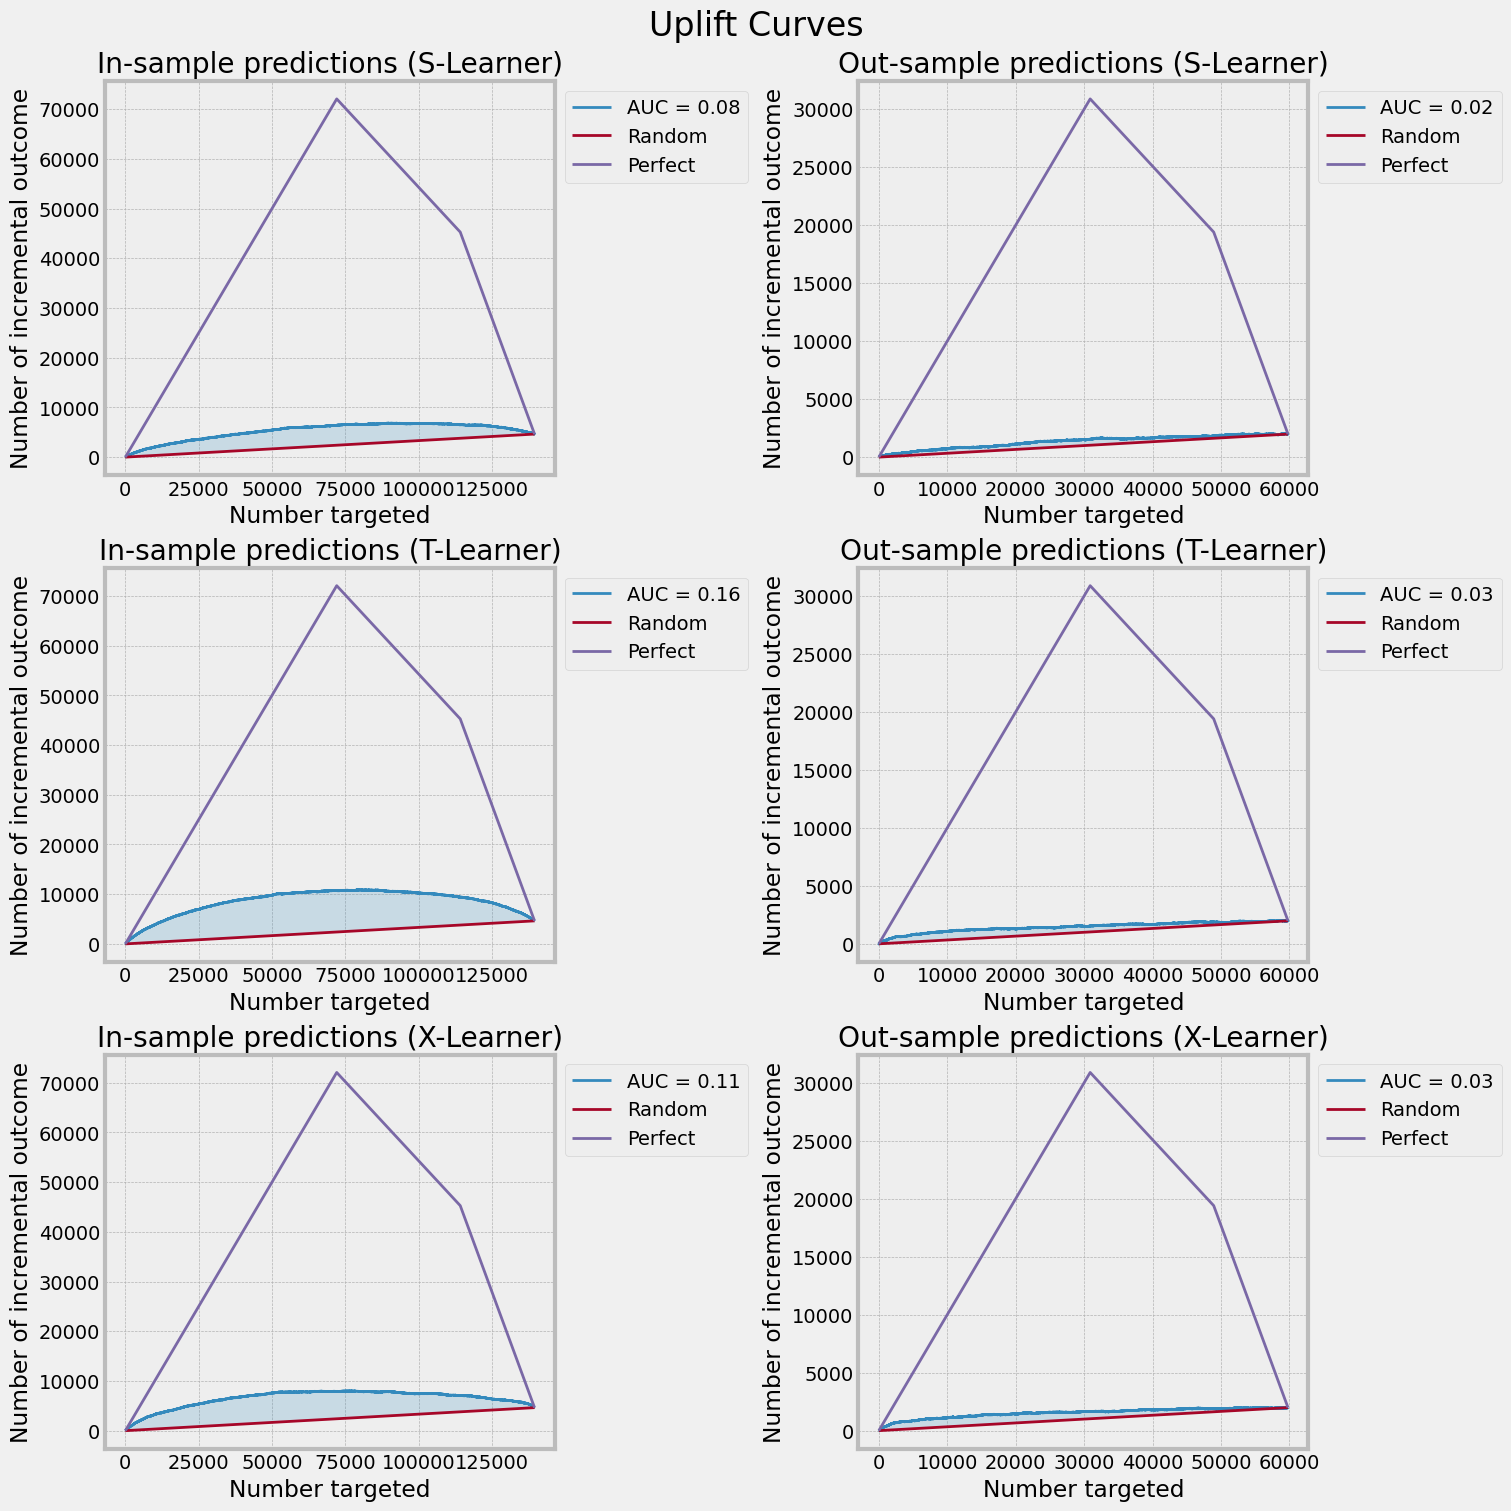

In [42]:
fig, axes = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(15, 15),
    layout="constrained"
)
 # in-sample
for i, data_out_train in enumerate(train_pred):
    ax = axes[i, 0]
    plot_uplift_curve(
        y_true=data_train.y,
        uplift=data_out_train.y_pred.flatten(),
        treatment=data_train.treatment,
        perfect=True,
        ax=ax
    )
    ax.set(title=f"In-sample predictions ({data_out_train.meta_learner_name})")

# out-of-sample
for j, data_out_val in enumerate(val_pred):
    ax = axes[j, 1]
    plot_uplift_curve(
        y_true=data_val.y,
        uplift=data_out_val.y_pred.flatten(),
        treatment=data_val.treatment,
        perfect=True,
        ax=ax
    )
    ax.set(title=f"Out-sample predictions ({data_out_val.meta_learner_name})")

fig.suptitle("Uplift Curves", fontsize=24);

**A remark on the perfect uplift curve:** ([Diemert, Eustache, et.al. (2020) "A Large Scale Benchmark for Uplift Modeling"](http://ama.imag.fr/~amini/Publis/large-scale-benchmark.pdf))
> A perfect model assigns higher scores to all treated individuals
with positive outcomes than any individuals with negative outcomes.

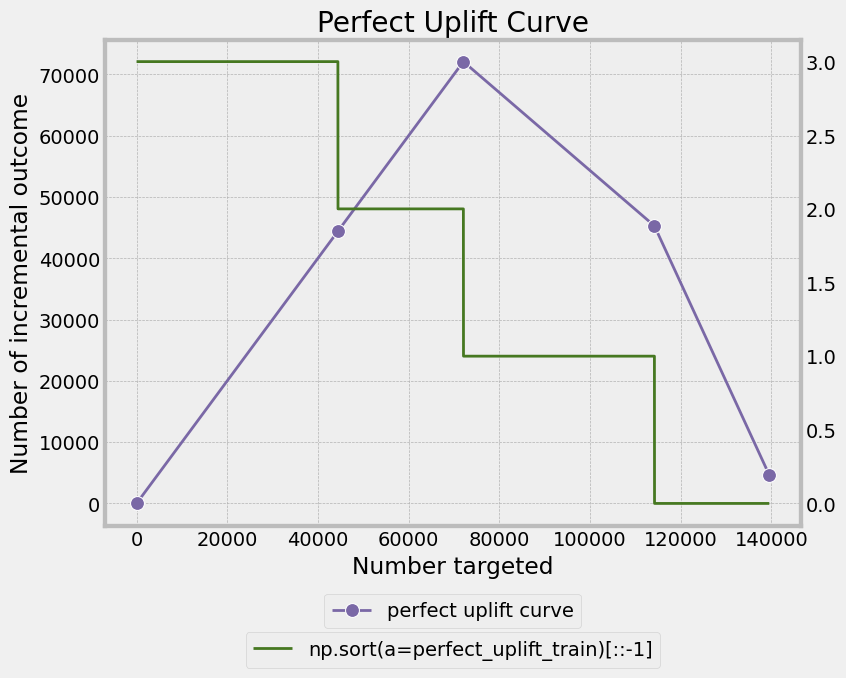

In [43]:
from sklift.metrics import uplift_curve

num_all, curve_values = uplift_curve(
    y_true=data_train.y,
    uplift=perfect_uplift_train,
    treatment=data_train.treatment
)

fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx() 
sns.lineplot(
    x=num_all,
    y=curve_values,
    color="C2",
    marker="o",
    markersize=10,
    label="perfect uplift curve",
    ax=ax1
)
sns.lineplot(
    x=range(data_train.y.size),
    y=np.sort(a=perfect_uplift_train)[::-1],
    color="C3",
    label="np.sort(a=perfect_uplift_train)[::-1]",
    ax=ax2
)
ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=1);
ax1.set(
    xlabel="Number targeted",
    ylabel="Number of incremental outcome",
    title="Perfect Uplift Curve"
)
ax2.grid(None)
ax2.legend(loc="upper center", bbox_to_anchor=(0.5, -0.20), ncol=1);

We can compare the perfect uplift curve against a random one:

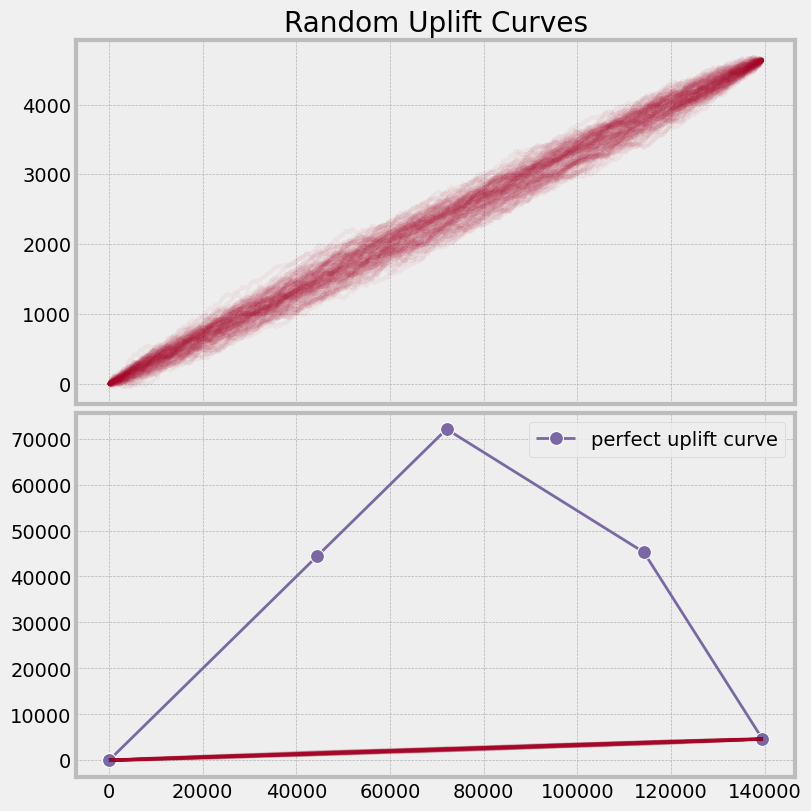

In [44]:
# number of random uplift curves to generate
n_random_samples = 100
# sample random uplift curves from a uniform distribution
uplift_random_samples = np.random.uniform(
    low=-1,
    high=1,
    size=(data_train.y.size, n_random_samples),
)
# compute uplift curve for each random sample
random_uplift_curves = [
    uplift_curve(
        y_true=data_train.y,
        uplift=uplift_random_samples[:, i],
        treatment=data_train.treatment
    )
    for i in range(n_random_samples)
]

# plot
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(8, 8),
    sharex=True,
    layout="constrained"
)
# perfect uplift curve
sns.lineplot(
    x=num_all,
    y=curve_values,
    color="C2",
    marker="o",
    markersize=10,
    label="perfect uplift curve",
    ax=ax[1]
)
# random uplift curves
for x, y in random_uplift_curves:
    ax[0].plot(x, y, color="C1", alpha=0.05)
    ax[1].plot(x, y, color="C1", alpha=0.05)
ax[0].set(title="Random Uplift Curves");

### Qini Curve

There is another variant for measuring the uplift, the *Qini curve*. It is defined as follows:

$$
g(t)
=
Y^{T}_{t}
-
Y^{C}_{t}
\left(
\frac{N^{T}_{t}}{N^{C}_{t}}
\right)
$$

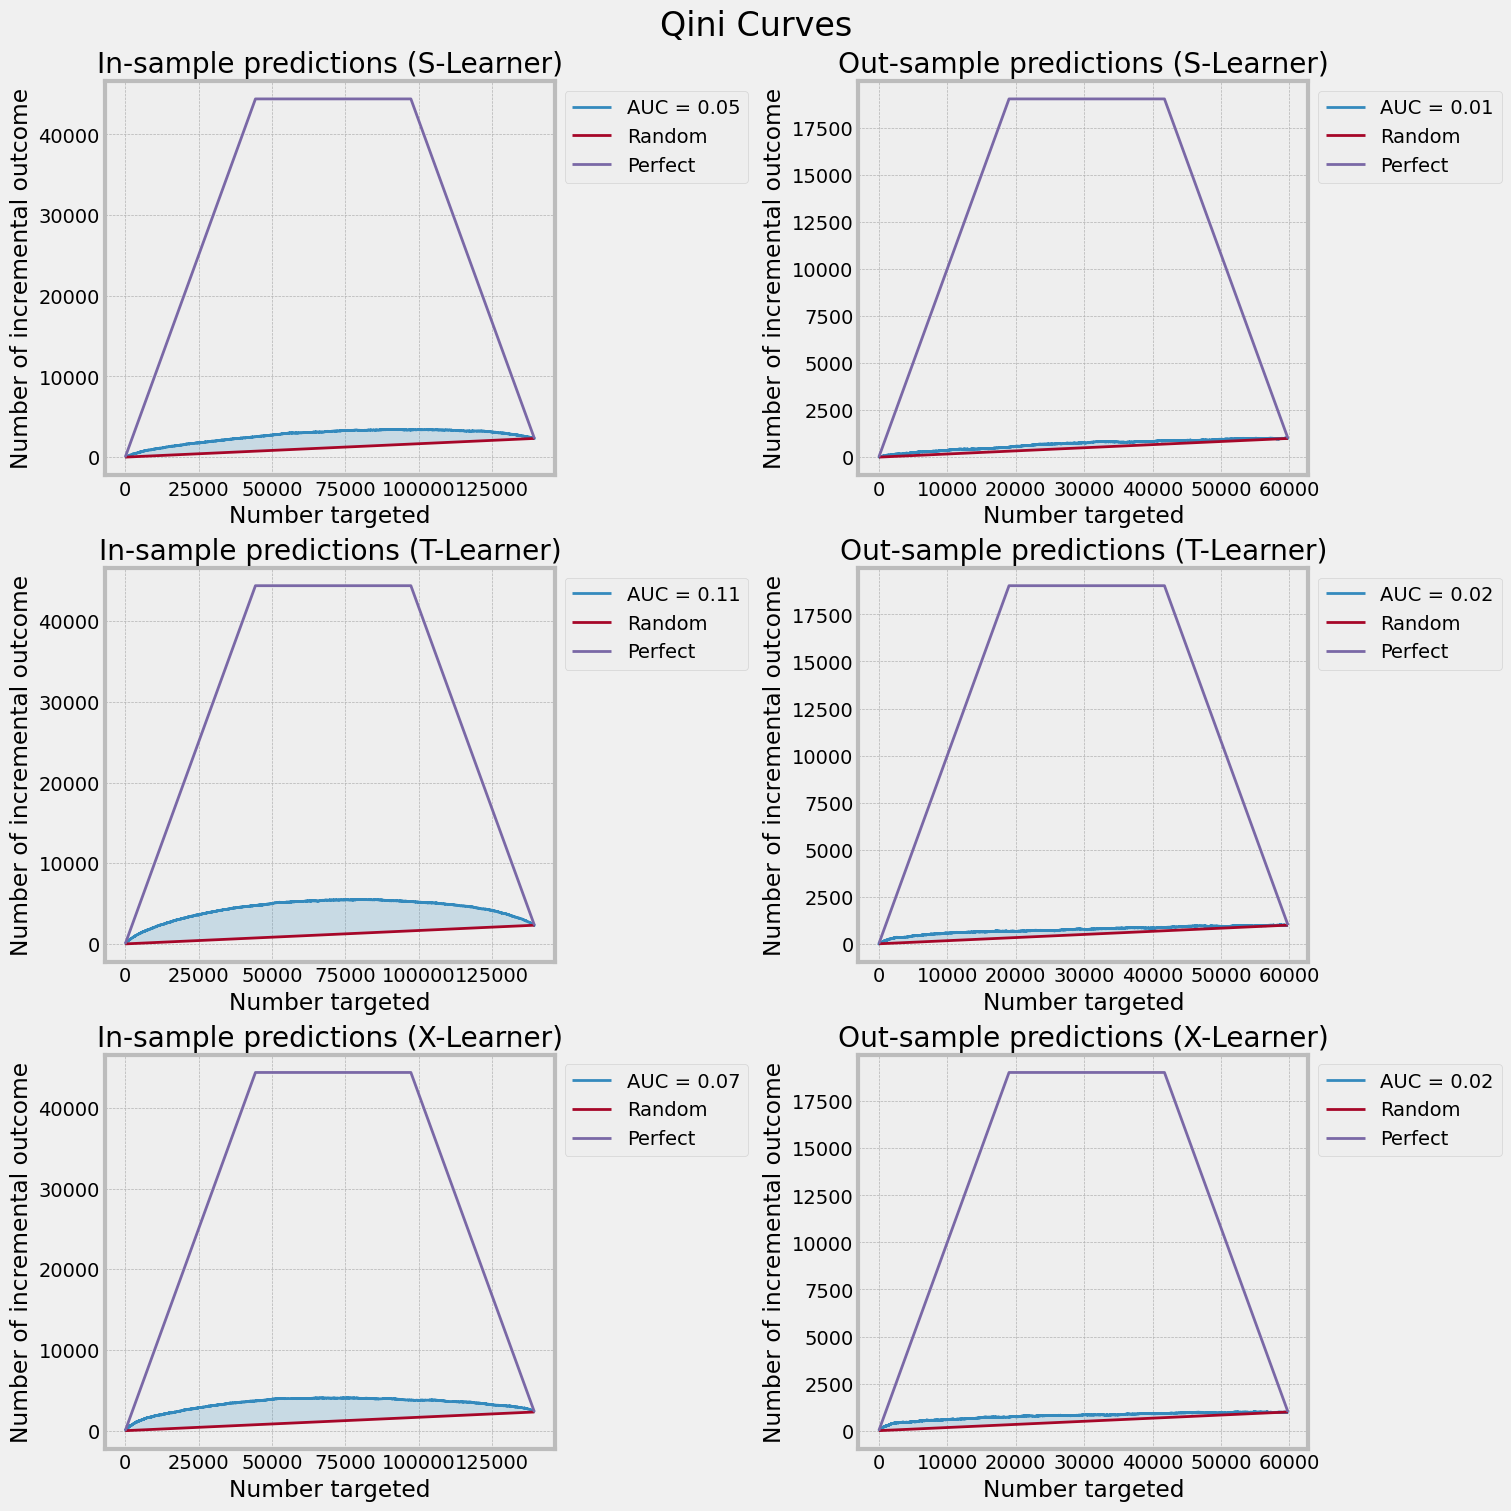

In [45]:
fig, axes = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(15, 15),
    layout="constrained"
)
 # in-sample
for i, data_out_train in enumerate(train_pred):
    ax = axes[i, 0]
    plot_qini_curve(
        y_true=data_train.y,
        uplift=data_out_train.y_pred.flatten(),
        treatment=data_train.treatment,
        perfect=True,
        ax=ax
    )
    ax.set(title=f"In-sample predictions ({data_out_train.meta_learner_name})")

# out-of-sample
for j, data_out_val in enumerate(val_pred):
    ax = axes[j, 1]
    plot_qini_curve(
        y_true=data_val.y,
        uplift=data_out_val.y_pred.flatten(),
        treatment=data_val.treatment,
        perfect=True,
        ax=ax
    )
    ax.set(title=f"Out-sample predictions ({data_out_val.meta_learner_name})")

fig.suptitle("Qini Curves", fontsize=24);

For more details on the Qini curve an related metrics see Section 4 in [Diemert, Eustache, et.al. (2020) *"A Large Scale Benchmark for Uplift Modeling"*](http://ama.imag.fr/~amini/Publis/large-scale-benchmark.pdf).